In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID, December 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
# @book{ebeling2004introduction,
#   title={An introduction to reliability and maintainability engineering},
#   author={Ebeling, C.E.},
#   isbn={9780070421387},
#   series={Electrical engineering series},
#   url={https://books.google.be/books?id=iFumyeVLIEAC},
#   year={2004},
#   publisher={McGraw-Hill}
# }

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot
from datetime import datetime, timedelta

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

#print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
choices = {'prod': ('productionfile.csv', 'prod_speed.csv'),
           'pack': ('packagingfile_old.csv', 'pack_speed.csv')}
file_used, file_speed = choices['pack']

round_to = 600 # seconds
break_pauses = 7200 # seconds # breaks will be split in these periods
turn_off_if = 3600 # seconds # the machine can be turned off if time if larger than this!!!! 
# turn_off_if has to be smaller than break_pauses in order for this program to run well
assert (turn_off_if < break_pauses)

In [3]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [4]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
reasons_relative = [1, 3, 5, 7, 8]
reasons_absolute = [9, 10, 11]
reasons_break = []
reasons_not_considered = [0, 2]
considered_reasons = reasons_relative + reasons_absolute + reasons_break
# group = True
choice='BigPack-simple'

# PLOT_RANGE:
plotrange = datetime(2016, 11, 3, 6, 0), datetime(2016, 12, 3, 0, 0)

assert (set(considered_reasons + reasons_not_considered) == set(all_reasons))

In [5]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType', 'BigPack-simple']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES'], ['HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    elif newname == choices[3]:
        stringlist = [ ['SMALL', ' 8', ' 10', ' 12'], ['LARGE', ' 16', ' 18', ' 20']]
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

## Merge per production

### Merge per production, Absolute reasons

In [6]:
from probplot import merge_per_production
df_agg = merge_per_production(df, [choice, 'ProductionRequestId', 'Type', 'ReasonId'], reasons_relative, reasons_absolute)

In [7]:
print(df_agg.index.get_level_values(0).unique())
df_agg.tail()

Index(['LARGE', 'Other', 'SMALL'], dtype='object', name='BigPack-simple')


DownTime1  DownTime3  DownTime5  \
BigPack-simple ProductionRequestId                                    
SMALL          508994                 19934.0     5609.0     4745.0   
               508995                 10218.0     2402.0     7649.0   
               508998                     0.0        0.0        0.0   
               508999                  5295.0     2736.0     3594.0   
               509003                  3828.0      468.0      865.0   

                                    DownTime7  DownTime8  DownTime  RunTime  \
BigPack-simple ProductionRequestId                                            
SMALL          508994                 19879.0     9379.0   59546.0  51848.0   
               508995                  5416.0     9469.0   35154.0  80776.0   
               508998                     0.0     1454.0    1454.0   4623.0   
               508999                     0.0     3765.0   15390.0  53310.0   
               509003                  2241.0     3053.0   10455.0  19139.0   

                                    TotalDuration  DownTimeRate  RunTimeRate  \
BigPack-simple ProductionRequestId                                             
SMALL          508994                    111394.0      0.534553     0.465447   
               508995                    115930.0      0.303235     0.696765   
               508998                      6077.0      0.239263     0.760737   
               508999                     68700.0      0.224017     0.775983   
               509003                     29594.0      0.353281     0.646719   

                                    DownTime9  DownTime10  DownTime11  \
BigPack-simple ProductionRequestId                                      
SMALL          508994                  2182.0      8571.0       306.0   
               508995                  1278.0         0.0         0.0   
               508998                  2690.0      1205.0         0.0   
               508999                   136.0         0.0         0.0   
               509003                   476.0     11408.0         0.0   

                                    Preparations  
BigPack-simple ProductionRequestId                
SMALL          508994                    11059.0  
               508995                     1278.0  
               508998                     3895.0  
               508999                      136.0  
               509003                    11884.0

C:\Users\jdavid\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


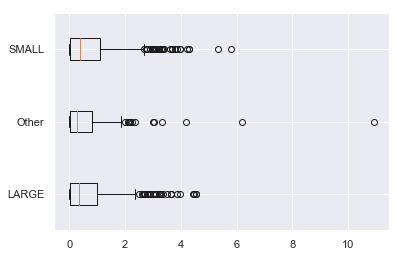

In [8]:
def get_downtimes_absolute(df_agg, column):    
    downtimes = []
    lab = df_agg.index.get_level_values(0).unique()
    for pastatype in lab:
        temp_df = df_agg.loc[pastatype]
        downtime9and10 = (temp_df[column])/3600
        downtimes.append(downtime9and10)
    return lab, downtimes
cat, downtimes = get_downtimes_absolute(df_agg, 'Preparations')
downtimes_dict = dict(zip(cat, downtimes))
plt.boxplot(downtimes, vert=False, labels=cat)
plt.show()

In [9]:
from scipy.stats.mstats import f_oneway
d_list = []
for downt in downtimes:
    d_list.append(np.array(downt))
f = f_oneway(*d_list)
print(f)
if f.pvalue >= 0.05:
    print('No statistical evidence of different distributions')
    stat=False
else:
    print('Statistical evidence of different distributions')
    stat=True

F_onewayResult(statistic=0.8137805002101628, pvalue=0.44343969869091626)
No statistical evidence of different distributions


(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

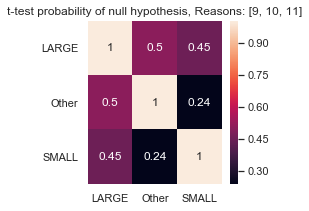

In [10]:
from scipy.stats import ttest_ind
from itertools import combinations, permutations
import seaborn as sns; sns.set()
row = list(df_agg.index.get_level_values(0).unique())
pvalues_df = pd.DataFrame(1, row, row)
for i, j in permutations(row, 2):
    tt = ttest_ind(downtimes_dict[i], downtimes_dict[j])
    pvalues_df.loc[i, j] = tt.pvalue
plt.figure(figsize=(len(row), len(row)))
sns.heatmap(pvalues_df, annot=True)
plt.title('t-test probability of null hypothesis, Reasons: {}'.format(reasons_absolute))
plt.yticks(rotation=0)
#plt.savefig('D:/temp/ttest.png', dpi=300, layout='tight')

In [11]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats.mstats import f_oneway
anova_list = []
for r in row:
    temp = df_agg.loc[r, 'RunTimeRate']
    anova_list.append(np.array(temp))
    #print(anova_list)
f = f_oneway(*anova_list)
print(f)
if f.pvalue >= 0.05:
    print('No statistical evidence of different distributions')
else:
    print('Statistical evidence of different distributions')

F_onewayResult(statistic=11.874042902891572, pvalue=7.884053018227206e-06)
Statistical evidence of different distributions


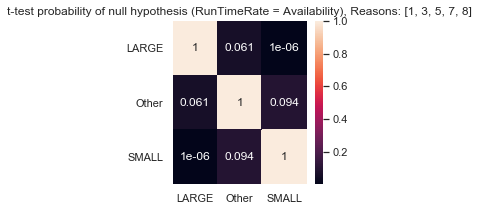

In [12]:
row = list(df_agg.index.get_level_values(0).unique())
from scipy.stats import ttest_ind
from itertools import combinations, permutations
import seaborn as sns; sns.set()
row = list(df_agg.index.get_level_values(0).unique())
pvalues_df = pd.DataFrame(1, row, row)
for i, j in permutations(row, 2):
    tt = ttest_ind(df_agg.loc[i, 'RunTimeRate'], df_agg.loc[j, 'RunTimeRate'])
    pvalues_df.loc[i, j] = tt.pvalue
plt.figure(figsize=(len(row), len(row)))
sns.heatmap(pvalues_df, annot=True)
plt.title('t-test probability of null hypothesis (RunTimeRate = Availability), Reasons: {}'.format(reasons_relative))
plt.yticks(rotation=0)
plt.savefig('D:/temp/ttest.png', dpi=300, bbox_inches ='tight')

In [13]:
from probplot import merge_per_article
df_merged = merge_per_article(df_agg, choice, reasons_relative)

In [14]:
df_merged[['Availability', 'DownTimeStd']]

,Availability,DownTimeStd
BigPack-simple,,
LARGE,0.780550,0.143177
Other,0.728848,0.175960
SMALL,0.655972,0.169544


### Export for simulator file and visualise

In [15]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        # This loop counts out the breaks and splits it in periods of maxtime and one period of maxtime + diff
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE',
                                     'Quantity': maxtime/3600})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                # overwrite the break time
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE',
                     'Quantity': diff/3600})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [16]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName', 'Quantity']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head(10)

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50788,2016-01-23 17:04:02.843,2016-01-23 18:12:44.100,4122.0,10,COQUILLETTES PPX 12x1KG,4500.0
1,50788,2016-01-23 18:12:44.100,2016-01-23 18:14:21.110,97.0,100,COQUILLETTES PPX 12x1KG,4500.0
2,50788,2016-01-23 18:14:21.110,2016-01-23 18:17:13.077,172.0,8,COQUILLETTES PPX 12x1KG,4500.0
3,50788,2016-01-23 18:17:13.077,2016-01-23 18:47:44.147,1831.0,100,COQUILLETTES PPX 12x1KG,4500.0
4,50788,2016-01-23 18:47:44.147,2016-01-23 18:52:24.153,280.0,5,COQUILLETTES PPX 12x1KG,4500.0
5,50788,2016-01-23 18:52:24.153,2016-01-23 19:01:05.263,521.0,100,COQUILLETTES PPX 12x1KG,4500.0
6,50788,2016-01-23 19:01:05.263,2016-01-23 19:11:11.200,606.0,8,COQUILLETTES PPX 12x1KG,4500.0
7,50788,2016-01-23 19:11:11.200,2016-01-23 19:16:46.240,335.0,100,COQUILLETTES PPX 12x1KG,4500.0
8,50788,2016-01-23 19:16:46.240,2016-01-23 19:19:50.237,184.0,5,COQUILLETTES PPX 12x1KG,4500.0
9,50788,2016-01-23 19:19:50.237,2016-01-23 19:21:20.230,90.0,100,COQUILLETTES PPX 12x1KG,4500.0


In [17]:
df_prod  = df_task[df_task.ArticleName != 'NONE']
prodtime = df_prod.Duration.sum() / 3600
uptime = df_prod.Duration[df_prod.ReasonId.isin([100])].sum() / 3600
downtime = df_prod.Duration[df_prod.ReasonId.isin(all_reasons)].sum() / 3600

reltime = df_prod.Duration[df_prod.ReasonId.isin(reasons_relative)].sum() / 3600
abstime = df_prod.Duration[df_prod.ReasonId.isin(reasons_absolute)].sum() / 3600
breaktime = df_prod.Duration[df_prod.ReasonId.isin(reasons_break)].sum() / 3600

idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('> Runtime {:.3f} h'.format(uptime))
print('> Downtime {:.3f} h'.format(downtime))

print('>> Unexpected breakdowns {:.3f} h'.format(reltime))
print('>> Expected breaks {:.3f} h'.format(abstime))
print('>> Pause {:.3f} h'.format(breaktime))

print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

av = uptime/prodtime
print('Availability production time:', av)

Production time 12445.151 h
> Runtime 8058.302 h
> Downtime 4386.849 h
>> Unexpected breakdowns 3196.942 h
>> Expected breaks 850.694 h
>> Pause 0.000 h
Idle time 3800.829 h
Total time 16245.980 h
Availability production time: 0.6475053882544123


27970


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


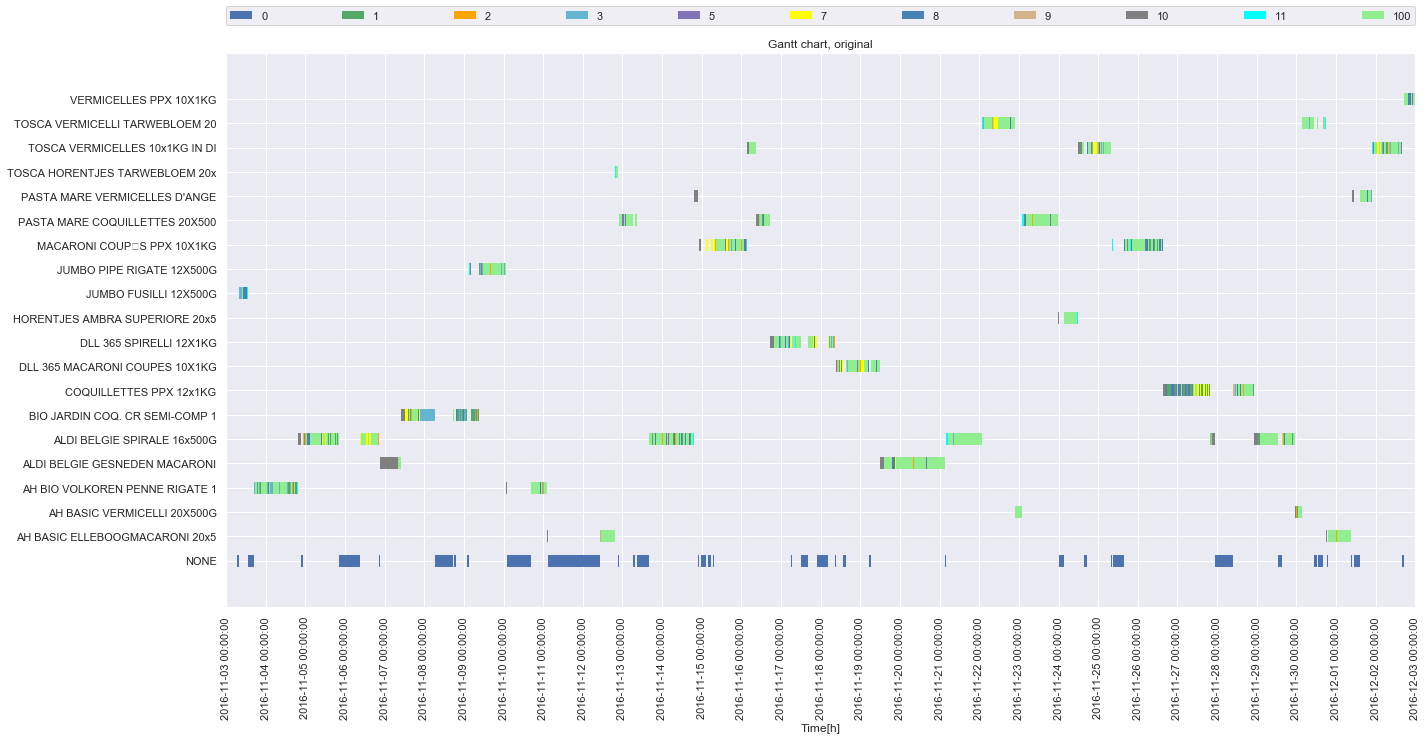

In [18]:
def show_gantt(df_task, start, end):
    plt.figure(figsize=(20, 10))
    # df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    # df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    df_part = df_task[df_task.StartDateUTC.between(start, end) & df_task.EndDateUTC.between(start, end)]
    all_reasons = list(df_task.ReasonId.unique())
    all_reasons.sort()
    plot_gantt(df_part, 'ReasonId', 'ArticleName', order=all_reasons)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # key_list = sorted(by_label)
    # value_list = [by_label[key] for key in key_list]
    # plt.legend(value_list, key_list, loc='lower right')
    plt.title('Gantt chart, original')
    #try:
    #    plt.savefig('D:/temp/gantt.svg', dpi=1200, bbox_inches='tight')
    #except:
    #    pass
    plt.tight_layout()
    plt.show()
show_gantt(df_task, *plotrange)

In [19]:
def sliding_plot(start, ran):
    from datetime import datetime, timedelta

    plotrange = datetime(2016, 11, 2, 0, 0) + timedelta(start), datetime(2016, 11, 2, 0, 0) + timedelta(start+ran)

    show_gantt(df_task, *plotrange)

In [20]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

a = widgets.FloatText()
b = widgets.FloatSlider(min=0, max=100, step=1)
display(a)
c = widgets.FloatSlider(min=1, max=14, step=1)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

interact(sliding_plot, start=b, ran=7)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='start', step=1.0), IntSlider(value=7, description='ran', max=21, min=-7), Output()), _dom_classes=('widget-interact',))

<function __main__.sliding_plot>

In [21]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [61]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'Quantity':'first','StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    #print(len(group))
    # all of the uptime is counted here
    group_uptime = df_task[df_task.ReasonId.isin([100])].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_uptime.columns = ['Uptime']
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime.columns = ['Totaltime']
    group_downtime = df_task[df_task.ReasonId.isin(considered_reasons)].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_downtime.columns = ['Downtime']
    group = pd.concat([group_uptime, group_downtime, group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.index = group.index.astype(int)
    group = group.fillna(0)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    #df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
#    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
#         if i == 0:
#             df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
#             df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
#             i += 1
#         df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
#         df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
#        df.loc[j, ]

    df['StartDateUTC'] = df['StartDateUTC'].dt.round(str(num_minutes) + 's')
    df['EndDateUTC'] = df['EndDateUTC'].dt.round(str(num_minutes) + 's')
    df['Duration'] = (df['EndDateUTC'] - df['StartDateUTC']).dt.total_seconds()
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Totaltime'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0): #& (df.loc[previdx, 'ArticleName'] != 'NONE'):
                # extend the previous job
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Totaltime'] += df.loc[curidx, 'Totaltime']
                df.loc[previdx, 'Uptime'] += df.loc[curidx, 'Uptime']
                df.loc[previdx, 'Downtime'] += df.loc[curidx, 'Downtime']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output, beforedays=None, randomfactor=None, ignore_break=False):
    out = group[['Uptime', 'Totaltime', 'Quantity', 'StartDateUTC', 'EndDateUTC', 'ArticleName']].copy()
    out.columns = ['Uptime', 'Totaltime', 'Quantity', 'Start', 'End', 'Product']
    out[['Uptime', 'Totaltime']] = out[['Uptime', 'Totaltime']] / 3600
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    to_convert_dates = ['Start', 'End']
    if beforedays:
        addedtime = np.full(np.array(out['End']).shape, beforedays)
        if randomfactor:
            addedtime += np.random.randint(randomfactor + 1, size=addedtime.shape)
        out['Before'] = pd.to_datetime(out['End']) + pd.to_timedelta(addedtime, unit="D")
        if ignore_break:
            out.loc[out['Product'] == 'NONE', 'Before']= out.loc[:,'End'].iloc[-1]
        to_convert_dates.append('Before')
    for col in to_convert_dates:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.index.name = 'ID'
    out.to_csv(output)
    
def construct_downtimes(group, reasons):
    dt = group.copy()
    dt = dt[dt['ReasonId'].isin(reasons)]
    return dt

def save_downtimes(dt, output):
    out = dt.copy()
    out = out[['StartDateUTC', 'EndDateUTC']]
    out = out.reset_index(drop=True)
    out.index.name = 'ID'
    out.to_csv(output)

#print(len(df_task))
group = group_productions(df_task)
#print(len(group))
print(group.columns)
group = remove_breaks(group, turn_off_if)
len(group)
#group = simplify_productions(group, 600)
#print(len(group))
downtime = construct_downtimes(df_task, considered_reasons)
save_downtimes(downtime, os.path.join(filepath, 'historicalDownPeriods.csv'))

Index(['Uptime', 'Downtime', 'Totaltime', 'Quantity', 'StartDateUTC',
       'EndDateUTC', 'ArticleName'],
      dtype='object')


In [62]:
group = add_column_type(group, choice=choice)

In [63]:
group.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,BigPack-simple
ProductionRequestId,,,,,,,,
50788,89367.0,52424.0,144775.990,4500.000000,2016-01-23 17:04:02.843,2016-01-25 09:16:58.020,COQUILLETTES PPX 12x1KG,SMALL
50787,0.0,12259.0,12259.000,1500.000000,2016-01-25 09:16:58.020,2016-01-25 12:41:17.787,ALDI BELGIE GESNEDEN MACARONI,Other
-2,0.0,0.0,5685.230,1.579231,2016-01-25 12:41:17.787,2016-01-25 14:16:03.017,NONE,Other
507870,22881.0,10687.0,34983.000,1500.000000,2016-01-25 14:16:03.017,2016-01-25 23:59:06.210,ALDI BELGIE GESNEDEN MACARONI,Other
-3,0.0,0.0,3969.563,1.102656,2016-01-25 23:59:06.210,2016-01-26 01:05:15.773,NONE,Other


In [64]:
prodtime = group.Totaltime[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Totaltime[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 12623.444 h
Idle time 3622.536 h
Total time 16245.980 h


In [88]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'), beforedays=7, randomfactor=7, ignore_break=True)
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [76]:
def energy_per_production(group, file_speed, choice=None, df_merged=None):
    articlenum = len(group.ArticleName.unique())
    fs = pd.read_csv(file_speed, index_col=0)
    fs = fs[fs.ProductDescription.isin(list(group.ArticleName))].reset_index(drop=True)
    #print(fs.ProductDescription)
    rand1 = pd.Series(np.random.random_sample((len(fs),)) * 0.2 + 0.1)
    rand2 = pd.Series(np.random.random_sample((len(fs),)) * 0.05 + 0.05)
    energycons = pd.concat([pd.Series(fs.ProductDescription), 
                            rand1,
                            rand2, 
                            pd.Series(fs.TargetProductionRate)], axis=1)
    if choice:
        assert(df_merged is not None)
        energycons = add_column_type(energycons, from_col='ProductDescription', choice=choice)
        energycons = energycons.merge(df_merged[['Availability']], left_on=choice, right_index=True)
        energycons = energycons.drop(choice, axis=1)
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate', 'Availability']
    else:
        energycons.columns = ['Product', 'UnitPrice',  'Power', 'TargetProductionRate']
    #energycons.insert(1, 'UnitPrice', 5)
    #energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    #energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    if choice:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 'Power': 0, 'TargetProductionRate': 1,
                                       'Availability': 1}, ignore_index=True)   
    else:
        energycons = energycons.append({'Product': 'NONE', 'UnitPrice': 0, 
                                        'Power': 0, 'TargetProductionRate': 1}, ignore_index=True)
    return energycons

energycons = energy_per_production(group, os.path.join(filepath, file_speed), choice=choice, df_merged=df_merged)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [77]:
group.head(2)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,BigPack-simple
ProductionRequestId,,,,,,,,
50788,89367.0,52424.0,144775.99,4500.0,2016-01-23 17:04:02.843,2016-01-25 09:16:58.020,COQUILLETTES PPX 12x1KG,SMALL
50787,0.0,12259.0,12259.00,1500.0,2016-01-25 09:16:58.020,2016-01-25 12:41:17.787,ALDI BELGIE GESNEDEN MACARONI,Other


In [78]:
energycons.tail(2)

,Product,UnitPrice,Power,TargetProductionRate,Availability
75,WINNY VERMICELLI 10x1KG,0.272656,0.054678,244,0.655972
76,NONE,0.000000,0.000000,1,1.000000


In [79]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [80]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [81]:
downtime.head(2)

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName,Quantity
0,50788,2016-01-23 17:04:02.843,2016-01-23 18:12:44.100,4122.0,10,COQUILLETTES PPX 12x1KG,4500.0
2,50788,2016-01-23 18:14:21.110,2016-01-23 18:17:13.077,172.0,8,COQUILLETTES PPX 12x1KG,4500.0


In [82]:
plotrange

(datetime.datetime(2016, 11, 3, 6, 0), datetime.datetime(2016, 12, 3, 0, 0))

C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

-1168


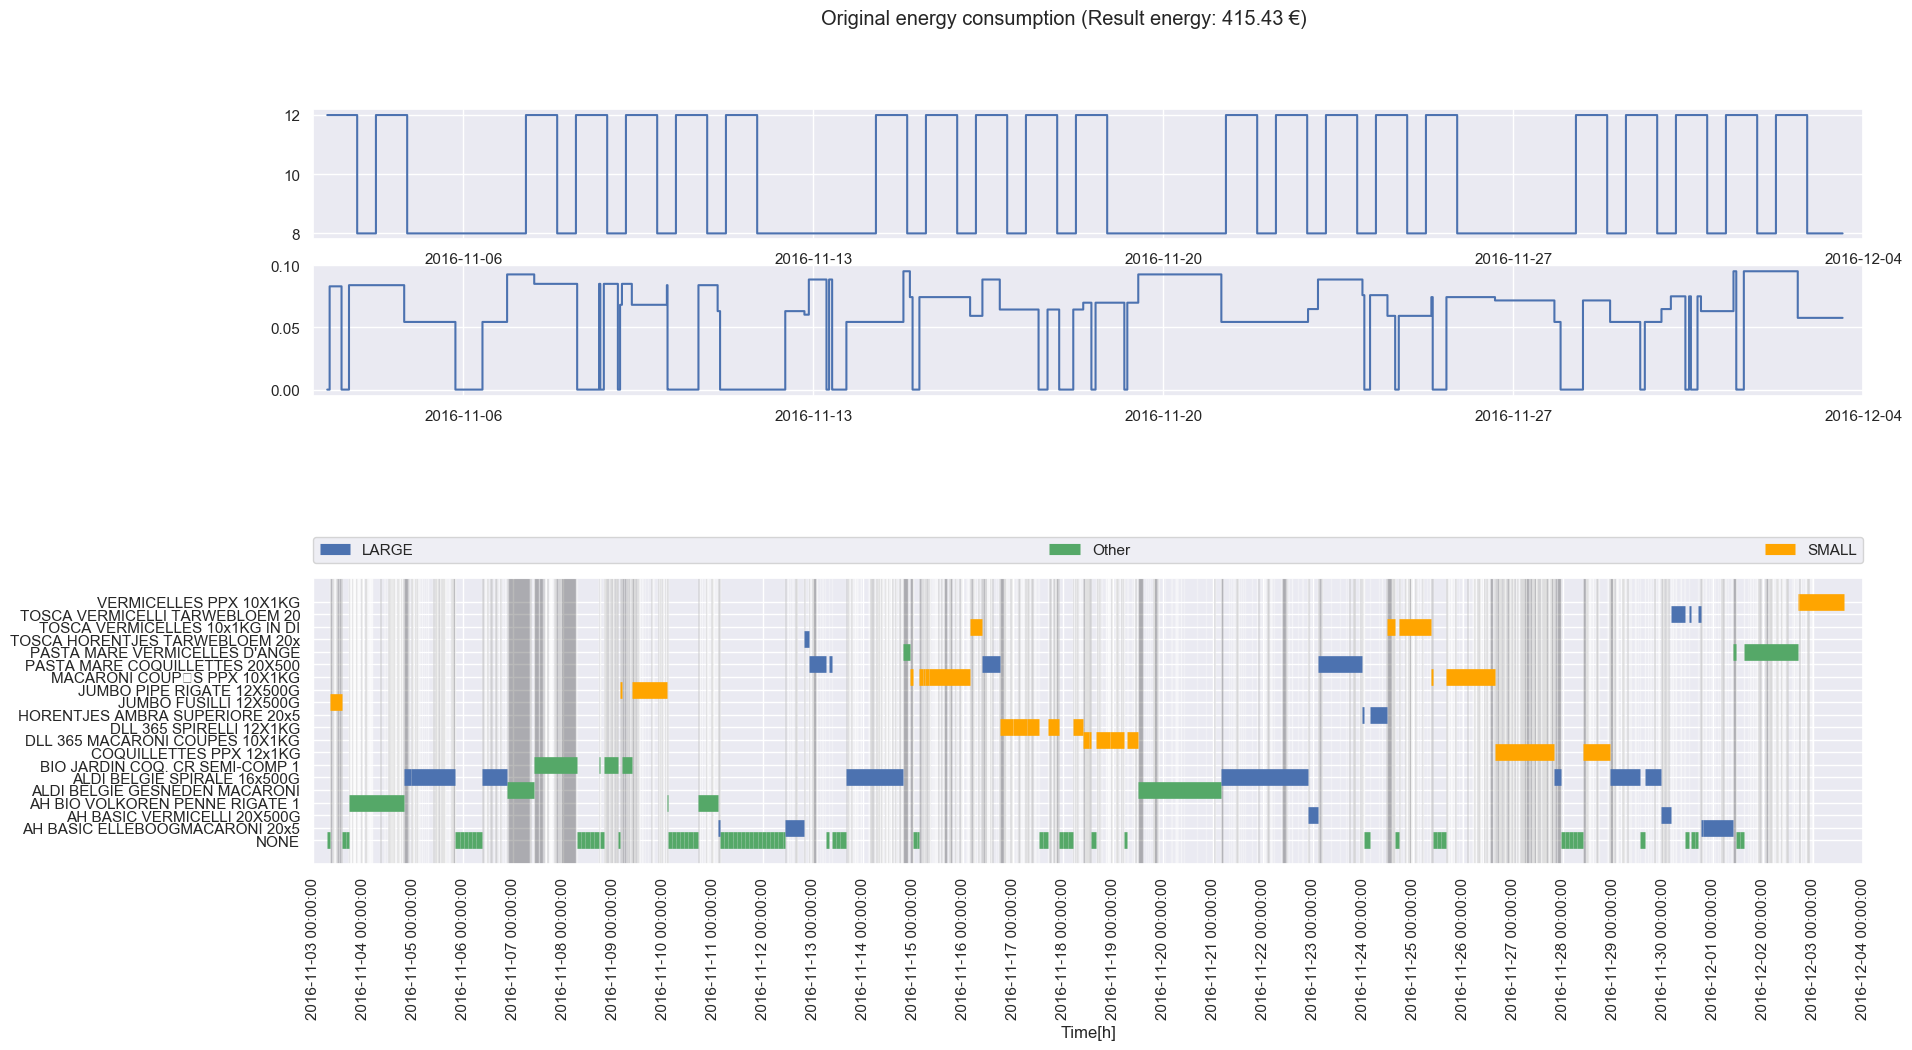

In [83]:
group_part = group[group.StartDateUTC.between(*plotrange)]
downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

plt.figure(figsize=(20, 10), dpi=100)
c, table = calculate_energy_cost(group_part, prices, energycons, True)

plt.subplot(5,1,(4,5))
timerange = plot_gantt(add_column_type(group_part, choice=choice), choice, 'ArticleName', downtimes=downtime_temp)
plt.subplot(5,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(5,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
try:
    plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
except:
    print('No output made.')
    pass
plt.show()

In [84]:
group_part.head(2)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,BigPack-simple,Start,End
ProductionRequestId,,,,,,,,,,
-1168,0.0,0.0,4136.923,1.149145,2016-11-03 06:37:44.397,2016-11-03 07:46:41.320,NONE,Other,6.628999,7.778144
508445,5423.0,15145.0,20568.000,3800.000000,2016-11-03 07:46:41.320,2016-11-03 13:29:29.550,JUMBO FUSILLI 12X500G,SMALL,7.778144,13.491542


In [85]:
# start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
# end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
# start_time, end_time

In [86]:
break

SyntaxError: 'break' outside loop (<ipython-input-86-6aaf1f276005>, line 1)

In [ ]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, mean_curve, worst_curve, gen = run_opt(*plotrange, 
       [], [],
        *files, 
        1, 10000, 0.4, 0.4, 12, num_mutations=1, adaptive=[],
        stop_condition='num_iterations', stop_value=None, 
        weight_energy = 1, weight_failure=0, weight_conversion = 1, weight_before = 10000)

Using historical method
Unexpected error when reading down duration information from '[]'


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:1367: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  warnings.warn('Import of downtime durations failed, using scheduling without failure information.')


In [89]:
best_sched = list(best_sched.keys())

In [90]:
def reorder_schedule(id_list, schedule):
    df = schedule.loc[id_list]
    startdate = df['StartDateUTC'].min()
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Totaltime'], unit='s')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [91]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,BigPack-simple,ReasonId
ProductionRequestId,,,,,,,,,
-1254,0.0,0.0,9887.423,2.0,2016-11-03 06:37:44.397,2016-11-03 09:22:31.820,NONE,Other,0
-1195,0.0,0.0,7200.000,2.0,2016-11-03 09:22:31.820,2016-11-03 11:22:31.820,NONE,Other,0
508485,15568.0,1607.0,17184.000,1000.0,2016-11-03 11:22:31.820,2016-11-03 16:08:55.820,AH BASIC VERMICELLI 20X500G,LARGE,100
508453,1877.0,21311.0,24277.000,3800.0,2016-11-03 16:08:55.820,2016-11-03 22:53:32.820,BIO JARDIN COQ. CR SEMI-COMP 1,Other,100
508479,123.0,4244.0,4367.000,250.0,2016-11-03 22:53:32.820,2016-11-04 00:06:19.820,DLL 365 MACARONI COUPES 10X1KG,SMALL,100


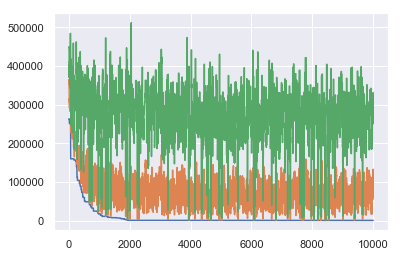

In [92]:
plt.plot(best_curve)
plt.plot(mean_curve)
plt.plot(worst_curve)

In [93]:
group_opt.head(10)

,Uptime,Downtime,Totaltime,Quantity,StartDateUTC,EndDateUTC,ArticleName,BigPack-simple,ReasonId
ProductionRequestId,,,,,,,,,
-1254,0.0,0.0,9887.423,2.0,2016-11-03 06:37:44.397,2016-11-03 09:22:31.820,NONE,Other,0
-1195,0.0,0.0,7200.000,2.0,2016-11-03 09:22:31.820,2016-11-03 11:22:31.820,NONE,Other,0
508485,15568.0,1607.0,17184.000,1000.0,2016-11-03 11:22:31.820,2016-11-03 16:08:55.820,AH BASIC VERMICELLI 20X500G,LARGE,100
508453,1877.0,21311.0,24277.000,3800.0,2016-11-03 16:08:55.820,2016-11-03 22:53:32.820,BIO JARDIN COQ. CR SEMI-COMP 1,Other,100
508479,123.0,4244.0,4367.000,250.0,2016-11-03 22:53:32.820,2016-11-04 00:06:19.820,DLL 365 MACARONI COUPES 10X1KG,SMALL,100
508449,27867.0,13114.0,42573.973,9000.0,2016-11-04 00:06:19.820,2016-11-04 11:55:53.793,ALDI BELGIE SPIRALE 16x500G,LARGE,100
508484,121582.0,25722.0,149785.997,5700.0,2016-11-04 11:55:53.793,2016-11-06 05:32:19.790,ALDI BELGIE SPIRALE 16x500G,LARGE,100
508452,695.0,1449.0,2144.000,3800.0,2016-11-06 05:32:19.790,2016-11-06 06:08:03.790,BIO JARDIN COQ. CR SEMI-COMP 1,Other,100
508488,25736.0,3009.0,30051.007,1800.0,2016-11-06 06:08:03.790,2016-11-06 14:28:54.797,HORENTJES AMBRA SUPERIORE 20x5,LARGE,100


-1254


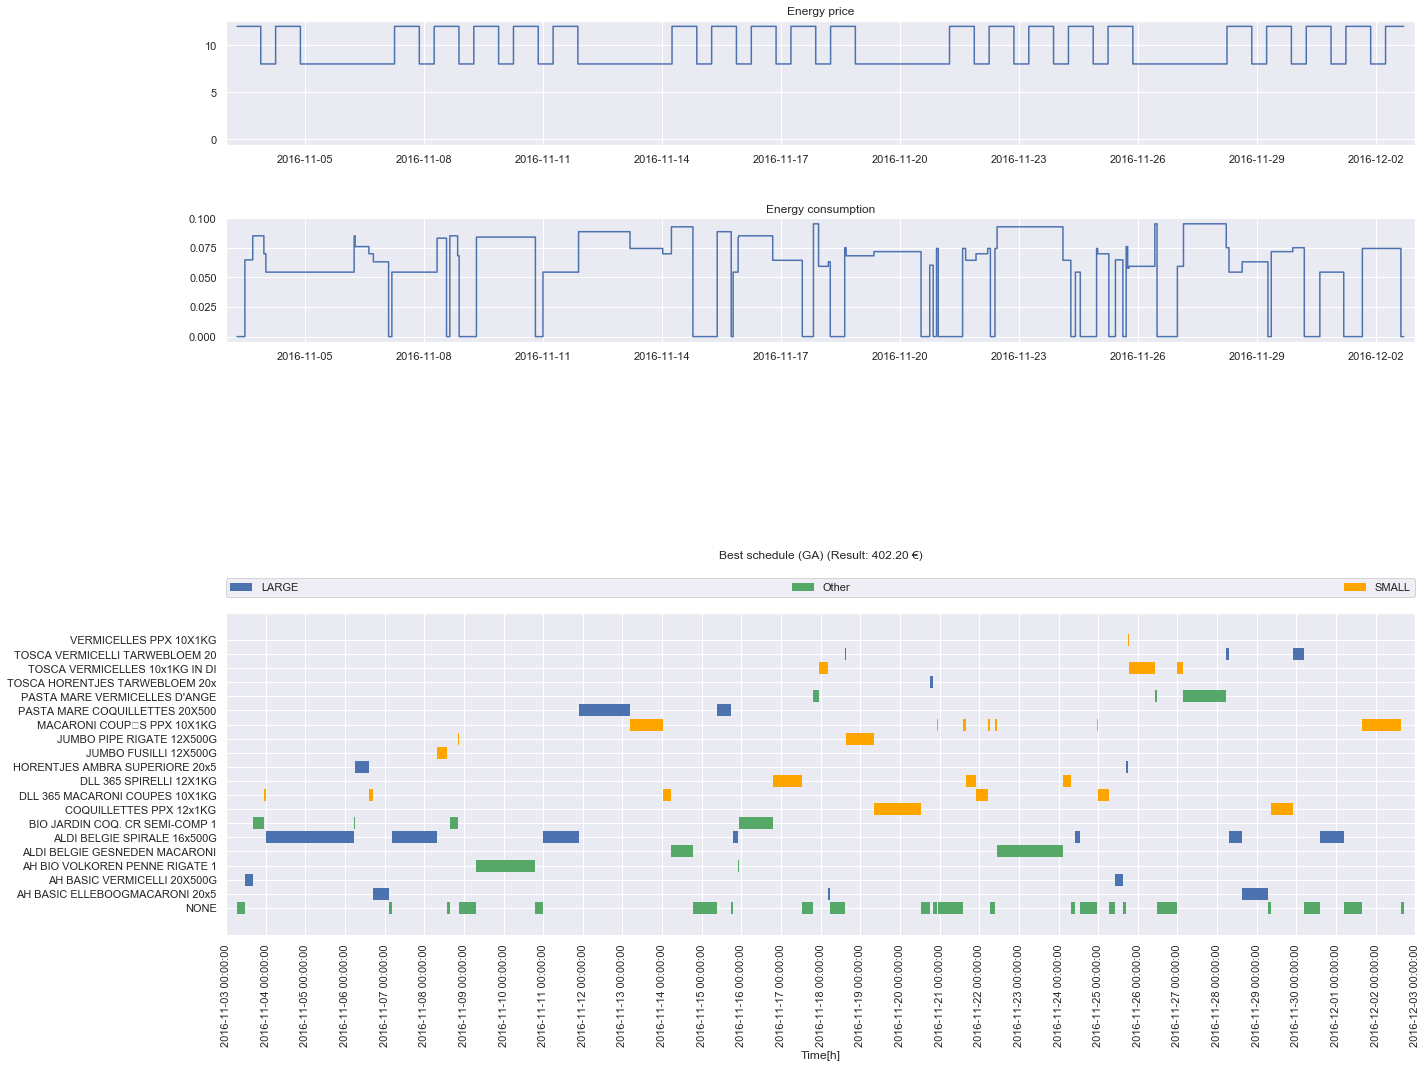

In [94]:
plt.figure(figsize=(20, 15))
show_energy_plot(add_column_type(group_opt, choice=choice), prices, energycons, 'Best schedule (GA)', choice, 
                 #downtimes=downtime_temp
                )
plt.show()

In [75]:
# group_part = group_opt[group_opt.StartDateUTC.between(*plotrange)]
# downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

# plt.figure(figsize=(20, 10))
# c, table = calculate_energy_cost(group_part, prices, energycons, True)

# plt.subplot(5,1,(4,5))
# timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
# plt.subplot(5,1,1)
# plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Euro, drawstyle='steps-post')

# plt.subplot(5,1,2)
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Power, drawstyle='steps-post')
# try:
#     plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
# except:
#     print('No output made.')
#     pass
# plt.show()

In [76]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [77]:
# df_task.Resource.unique()

In [78]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [79]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours